In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/notebooks/glac/data/T.csv")
raw_dataset = pd.read_csv("~/stuff/coding/glacier/glac/data/T.csv")

# , sep='|', names=['col1']
# , delimiter=", ' "

dataset = raw_dataset.copy()

#examine missing data
dataset.head()

2.6.0


,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,GLACIER_DB,GLACIER_ID,LAT,LON,SURVEY_DATE,ELEVATION_DATE,AREA,...,SURVEY_METHOD_DETAILS,NUMBER_OF_SURVEY_POINTS,NUMBER_OF_SURVEY_PROFILES,TOTAL_LENGTH_OF_SURVEY_PROFILES,INTERPOLATION_METHOD,INVESTIGATOR,SPONSORING_AGENCY,REFERENCES,DATA_FLAG,REMARKS
0,1,SE,ISFALLSGLAC,WGI,SE4B000E0006,67.91500,18.56800,19790399.0,19799999.0,1.3,...,NaN,NaN,NaN,NaN,NaN,Schytt V. and others,University of Iceland,"Björnsson, H., (1981). Geogr. Ann.",NaN,NaN
1,2,SE,RABOTS GLACIAER,WGI,SE4B000E1016,67.91000,18.49600,19790399.0,19799999.0,4.1,...,NaN,NaN,10.0,NaN,NaN,Schytt V. and others,University of Iceland,"Björnsson, H., (1981). Geogr. Ann.",NaN,NaN
2,3,SE,STORGLACIAEREN,WGI,SE4B000E0005,67.90000,18.57000,19790399.0,19799999.0,3.1,...,NaN,NaN,NaN,NaN,NaN,Schytt V. and others,University of Iceland,"Björnsson, H., (1981). Geogr. Ann.",NaN,NaN
3,4,US,SOUTH CASCADE,WGI,US2M00264006,48.35698,-121.05735,19759999.0,19759999.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Driedger, C.L., and Kennard, P.M., (1986a). An...",NaN,NaN
4,5,CA,ATHABASCA,FOG,7,52.17540,-117.28400,NaN,NaN,3.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Driedger, C.L., and Kennard, P.M., (1986a). An...",NaN,NaN


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

#sum up rows with empty cells
dataset.isna().sum()

#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()

LAT               0
LON               0
AREA              0
MEAN_SLOPE        0
MEAN_THICKNESS    0
dtype: int64

In [3]:
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


# 

In [4]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

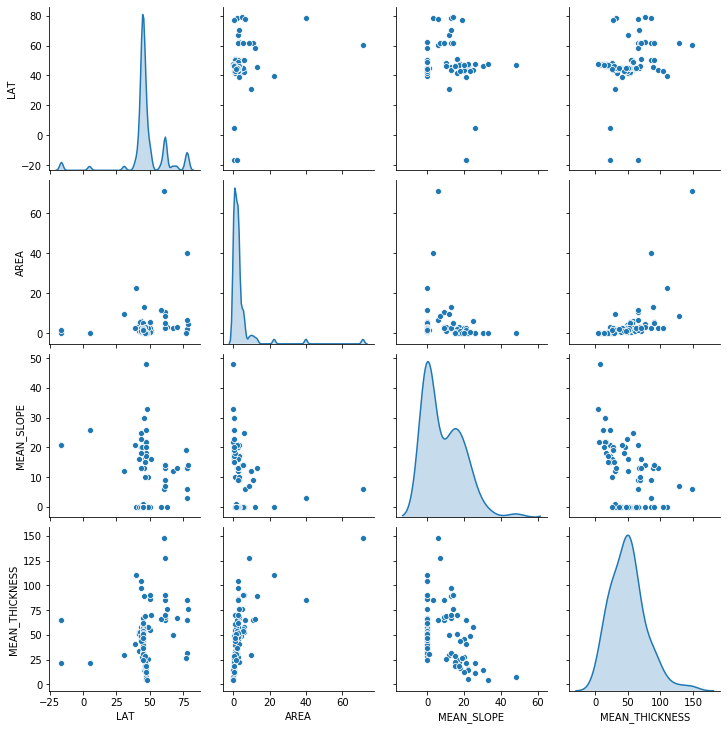

In [5]:
sns.pairplot(train_dataset[["LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.465341,14.458029,-16.3023,44.584600,45.080000,48.75000,78.87100
LON,89.0,41.704321,55.546192,-134.3600,8.602228,78.176022,79.82588,140.86536
AREA,89.0,4.060882,8.853776,0.0264,1.000000,2.100000,3.22750,71.30000
MEAN_SLOPE,89.0,8.797753,10.230502,0.0000,0.000000,6.000000,16.00000,48.00000
MEAN_THICKNESS,89.0,50.460674,27.011806,4.0000,30.000000,49.000000,65.00000,148.00000


In [7]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


# Establish normalization layers

In [8]:
#build normalizer layers for each model to be run

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

area = train_features["AREA"]
area_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
area_normalizer.adapt(np.array(area))

lat = train_features["LAT"]
lat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lat_normalizer.adapt(np.array(lat))

lon = train_features["LON"]
lon_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lon_normalizer.adapt(np.array(lon))


slope = train_features["MEAN_SLOPE"]
slope_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
slope_normalizer.adapt(np.array(slope))

# Define model functions

In [9]:
# def build_and_compile_model(norm):
#     model = keras.Sequential([
#       norm,
#       layers.Dense(64, activation='relu'),
#       layers.Dense(64, activation='relu'),
#       layers.Dense(1)
#   ])

#     model.compile(loss='mean_absolute_error',
#                 optimizer=tf.keras.optimizers.Adam(0.1))
#     return model



# def build_model(area_normalizer):
#     model = tf.keras.Sequential([
#         area_normalizer,
#         layers.Dense(1)
#     ])

#     model.compile(
#         optimizer=tf.optimizers.Adam(learning_rate=0.1),
#         loss="mean_absolute_error")
#     return model



# def model_history(area):
#     history = model.fit(
#         area, train_labels,
#         epochs=1000,
#         verbose=0,
#         validation_split = 0.2)
#     return model_history

test_results = {}

# def test_results(AREA)
# test_results["area"] = model.evaluate(
#         test_features["AREA"],
#         test_labels, verbose=0)

# test_results

# Linear regression with area

In [10]:
# build_and_compile_model(area_normalizer)
# build_model(area_normalizer)

model = tf.keras.Sequential([
        area_normalizer,
        layers.Dense(1)
    ])
model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error")


history = model.fit(
   area, train_labels,
   epochs=1000,
   verbose=0,
   validation_split = 0.2)


test_results["area"] = model.evaluate(
        test_features["AREA"],
        test_labels, verbose=0)

test_results

{'area': 69.056640625}

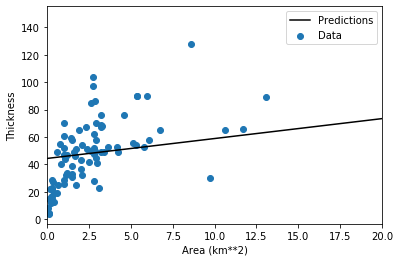

In [11]:
def plot_area(x, y):
    plt.scatter(area, train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Area (km**2)')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = model.predict(x)
plot_area(x,y)

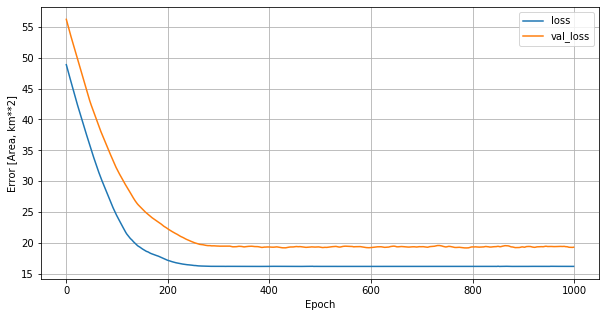

In [12]:
def plot_loss(history):
    plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Area, km**2]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

# Linear regression with latitude

In [13]:
# build_model(lat_normalizer)

model = tf.keras.Sequential([
    lat_normalizer,
    layers.Dense(1)
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

# model_history(lat)
history = model.fit(
    lat, train_labels,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

test_results["lat"] = model.evaluate(
    test_features["LAT"],
    test_labels, verbose=0)

test_results

{'area': 69.056640625, 'lat': 27.267850875854492}

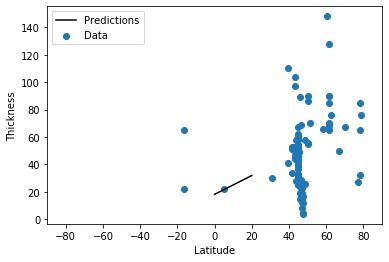

In [14]:
def plot_lat(x, y):
    plt.scatter(lat, train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel("Latitude")
    plt.ylabel('Thickness')
    plt.xlim((-90,90))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = model.predict(x)
plot_lat(x,y)

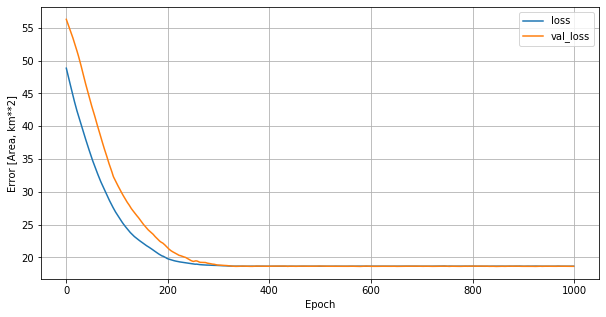

In [15]:
plot_loss(history)

# Linear regression with longitude

In [16]:
# build_model(lon_normalizer)
# model_history(lon)

model = tf.keras.Sequential([
    lon_normalizer,
    layers.Dense(1)
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

history = model.fit(
    lon, train_labels,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

test_results["lon"] = model.evaluate(
    test_features["LON"],
    test_labels, verbose=0)

test_results

{'area': 69.056640625, 'lat': 27.267850875854492, 'lon': 29.499969482421875}

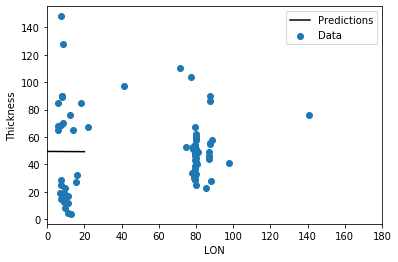

In [17]:
def plot_lon(x, y):
    plt.scatter(train_features["LON"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('LON')
    plt.ylabel('Thickness')
    plt.xlim((0,180))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = model.predict(x)
plot_lon(x,y)

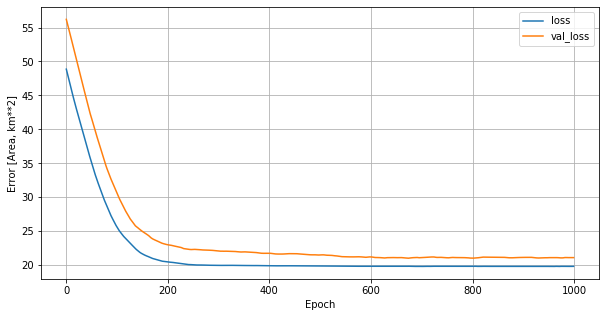

In [18]:
plot_loss(history)

# Linear regression with slope

In [19]:
model = tf.keras.Sequential([
    slope_normalizer,
    layers.Dense(1)
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.2),
    loss="mean_absolute_error")

history = model.fit(
    slope, train_labels,
    epochs=800,
    verbose=0,
    validation_split = 0.3)

test_results["slope"] = model.evaluate(
    test_features["MEAN_SLOPE"],
    test_labels, verbose=0)

test_results

{'area': 69.056640625,
 'lat': 27.267850875854492,
 'lon': 29.499969482421875,
 'slope': 24.331262588500977}

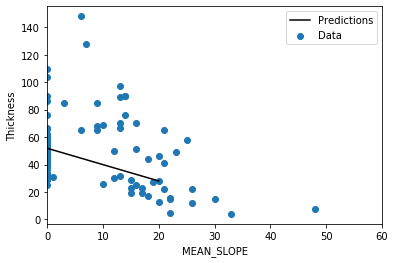

In [20]:
def plot_slope(x, y):
    plt.scatter(train_features["MEAN_SLOPE"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('MEAN_SLOPE')
    plt.ylabel('Thickness')
    plt.xlim((0,60))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = model.predict(x)
plot_slope(x,y)

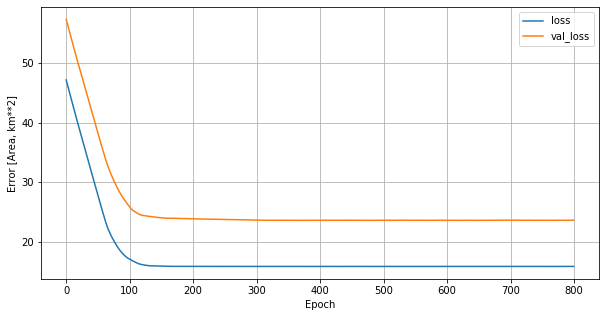

In [21]:
plot_loss(history)

# Multiple inputs

In [22]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

history = model.fit(
    train_features, train_labels, 
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


test_results["multi_model"] = model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'area': 69.056640625,
 'lat': 27.267850875854492,
 'lon': 29.499969482421875,
 'slope': 24.331262588500977,
 'multi_model': 50.29378890991211}

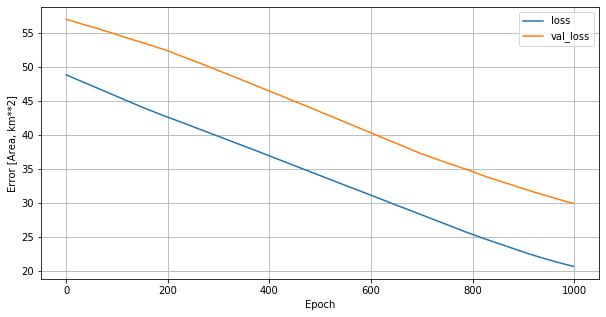

In [23]:
plot_loss(history)

# DNN regression

### Single variable

In [24]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    return model

In [25]:
dnn_area_model = build_and_compile_model(area_normalizer)

In [26]:
%%time
history_dnn = dnn_area_model.fit(
    train_features["AREA"], train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=500)

CPU times: user 8.77 s, sys: 442 ms, total: 9.21 s
Wall time: 8.13 s


In [27]:
test_results['dnn_model'] = dnn_area_model.evaluate(
    test_features["AREA"], test_labels,
    verbose=0)

# Full model

In [28]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
dnn_full_model = build_and_compile_model(normalizer)

In [29]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 1.9 s, sys: 109 ms, total: 2 s
Wall time: 1.76 s


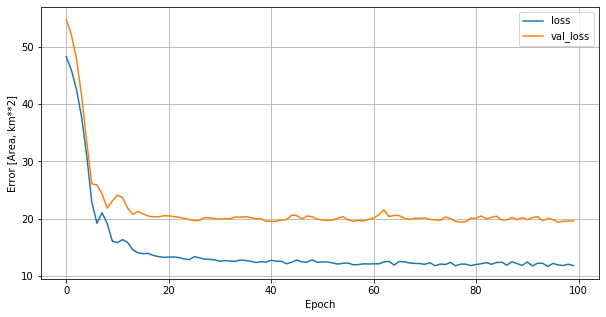

In [30]:
plot_loss(history_full)

Text(0, 0.5, 'Model Area (km**2)')

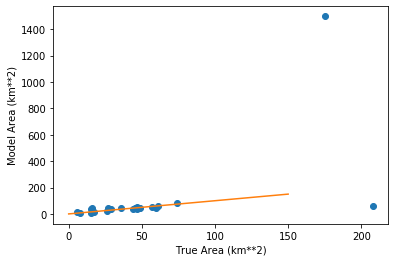

In [31]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'o')
plt.plot((0,150),(0,150),'-')
plt.xlabel('True Area (km**2)')
plt.ylabel('Model Area (km**2)')

Text(0, 0.5, 'Count')

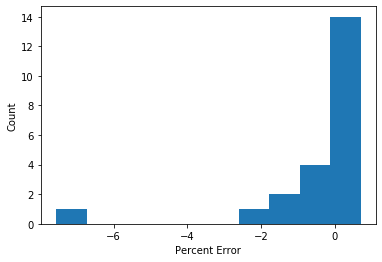

In [32]:
plt.subplots()
x = np.reshape(test_labels.values, (-1, 1)) # Training values in a n-by-1 array
pct_error = (x-y)/x
plt.hist(pct_error.flatten())
plt.xlabel('Percent Error')
plt.ylabel('Count')

In [33]:
test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'area': 69.056640625,
 'lat': 27.267850875854492,
 'lon': 29.499969482421875,
 'slope': 24.331262588500977,
 'multi_model': 50.29378890991211,
 'dnn_model': 44.195980072021484,
 'dnn_full_model': 74.64459991455078}